In [1]:
import os
import statistics
import json
import glob
from matplotlib import pyplot as plt
from posixpath import basename
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import csv
import matplotlib.colors as mcolors
import regex

In [2]:
discr_dict={'P1':1,'P2':2,'P3':3,'P4':4,'Q1':5,'Q2':6}
# mesh_dict={"square_beam_0.5":0,"square_beam_0.25":1,"square_beam_0.1":2,"square_beam_0.05":3,"square_beam_0.025":4,"square_beam_0.01":5,"square_beam_0.005":6}
# mesh_dict={"square_beam_0.025":0,"square_beam_0.022":1,"square_beam_0.021":2,"square_beam_0.020":3,"square_beam_0.019":4,"square_beam_0.016":5,"square_beam_0.013":6,"square_beam_0.01":7}
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
class Cal_result(object):
    # solver_name="AMGCL"
    # json_name="bar"
    # discr_order=1
    # n_ref=1
    # block_size=1
    # repeat_times=5
    # result_json=[]
    # time=np.zeros((1,repeat_times),dtype=np.double)
    # iter=np.zeros((1,repeat_times),dtype=np.int32)
    # err=np.zeros((1,repeat_times),dtype=np.double)
    def __init__(self,solver_name_,mesh_name_,json_name_,discr_order_,n_ref_,block_size_,repeat_times_,num_thread_,num_vertices=0,iter_step=1):
        self.solver_name=solver_name_
        self.mesh_name=mesh_name_
        self.json_name=json_name_
        self.discr_order=discr_order_
        self.n_ref=n_ref_
        self.block_size=block_size_
        self.repeat_times=repeat_times_
        self.num_thread=num_thread_
        self.cpu_usage=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.peak_memory=0
        self.bc_solver_time=0
        self.bc_time=0
        self.linear_solver_time=0
        self.result_json=[None]*(repeat_times_+1)
        #From the json file
        self.mat_size=0
        self.nonzero=0
        self.time=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter=np.zeros((1,repeat_times_+1),dtype=np.int32)
        self.err=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter_step=iter_step
        self.num_vertices=num_vertices

In [3]:
def get_erriter(solver_name_,json_data_): 
    #return iter,err(0 if not exist,-1 if fail)
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::ConjugateGradient":
        return json_data_["solver_iter"], json_data_["solver_error"]

    if solver_name_=="Eigen::PardisoLDLT" or solver_name_=="Eigen::PardisoLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::SimplicialLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Catamari":
        return 0,0
    
    if ("num_iterations" in json_data_ ) and ("final_res_norm" in json_data_):
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    else:
        print(json_data_)
        raise Exception("Unknown json file format")



In [4]:
def stats(j_file_): 
    #return solving_time,iterations,error,mat_order
    with open(j_file_, 'r') as f:
        json_data = json.load(f)
    if json_data is None:
        raise Exception("Empty json file")
    if "solver_type" in json_data["args"]:
        solver_name=json_data["args"]["solver_type"]
    else:
        solver_name=json_data["args"]["solver"]["linear"]["solver"]
    tensor_formulation=json_data["formulation"]
    mat_size=json_data["mat_size"]
    num_vertices=json_data["num_vertices"]
    nonzero=json_data["num_non_zero"]
    peak_memory=json_data["peak_memory"]
    time_solving=json_data["time_solving"]
    num_iterations=0
    err=0
    solver_info=json_data["solver_info"]
    if (tensor_formulation=="NeoHookean") or (tensor_formulation=="IncompressibleOgden") \
    or (tensor_formulation=="MooneyRivlin") or (tensor_formulation=="SaintVenant") \
    or (tensor_formulation=="UnconstrainedOgden"):
        err_list=[]
        iter_list=[]
        iter_steps=0
        for tmp_info in json_data["solver_info"]:
            for temp in tmp_info["info"]["internal_solver"]:
                tempiter,temperr=get_erriter(solver_name,temp)
                err_list.append(temperr)
                iter_list.append(tempiter)
            iter_steps+=tmp_info["info"]["iterations"]
        err=statistics.mean(err_list)
        num_iterations=sum(iter_list)
        # Need to verify the mat_order
        return time_solving,num_iterations,err,mat_size,nonzero,peak_memory,num_vertices,iter_steps
    else:
        tempiter,temperr=get_erriter(solver_name,solver_info)
        return time_solving,tempiter,temperr,mat_size,nonzero,peak_memory,num_vertices,1
    # Add "if" for more problems                

In [5]:
def read_log(log_file_):
    #return bc_solver_time,bc_time,linear_solver_time
    bc_solver_time=-1
    bc_time=-1
    linear_solver_time=-1
    with open(log_file_, 'r') as f:
        for line in f:
            m=regex.search(r"bc time: [-+]?([0-9]*\.[0-9]+|[0-9]+)",line)
            n=regex.search(r"bc solver time: [-+]?([0-9]*\.[0-9]+|[0-9]+)",line)
            l=regex.search(r"linear time: [-+]?([0-9]*\.[0-9]+|[0-9]+)",line)
            if m!=None:
                bc_time=float(m.group(1))
            if n!=None:
                bc_solver_time=float(n.group(1))
            if l!=None:
                linear_solver_time=float(l.group(1))
    return bc_solver_time,bc_time,linear_solver_time

In [6]:
def read_cpu_usage(file):
    with open(file, "r") as f:
        lis = [line.split() for line in f] 
        l=len(list(enumerate(lis)))
        if(l==0):
            return -1
        else:
            usage=[]
            for i, line in enumerate(lis):
                if len(line)>4:
                    usage.append(float(line[-4])/100)
            return np.amax(usage)          

# Prepare data

In [7]:
def data_collect(path_lists,start_index):
    result_list=[]
    fail_list=[]
    for path_list in path_lists:
        for path in path_list:
            temp_path=path.split('/')
            solver_name=temp_path[0+start_index]
            mesh_name=temp_path[1+start_index]
            json_name=temp_path[2+start_index]
            discr_order=discr_dict[temp_path[3+start_index]]
            n_ref=int(temp_path[4+start_index][-1])
            block_size=int(temp_path[5+start_index][-1])
            if len(temp_path)==7+start_index:
                num_thread=int(temp_path[6+start_index].strip("Thread"))
            else:
                num_thread=-1
            repeat_path=glob.glob(os.path.join(path,"*"))
            repeat_times=max(map(int,map(os.path.basename,repeat_path)))
            temp_result=Cal_result(solver_name,mesh_name,json_name,discr_order,n_ref,block_size,repeat_times,num_thread)
            exist_bool=True
            for inner_path in repeat_path:
                repeat_time=int(os.path.basename(inner_path))
                json_path=os.path.join(inner_path,"json","result.json")
                cpu_path=os.path.join(inner_path,"output","cpu.txt")
                log_path=os.path.join(inner_path,"output","log.txt")
                if os.path.exists(json_path):
                    temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time],temp_result.mat_size,temp_result.nonzero,temp_result.peak_memory,temp_result.num_vertices,temp_result.iter_step=stats(json_path)
                    temp_result.result_json[repeat_time]=inner_path
                    if os.path.exists(cpu_path):
                        temp_result.cpu_usage[0,repeat_time]=read_cpu_usage(cpu_path)
                    else:
                        temp_result.cpu_usage[0,repeat_time]=0
                    if os.path.exists(log_path):
                        temp_result.bc_solver_time,temp_result.bc_time,temp_result.linear_solver_time=read_log(log_path)
                    else:
                        temp_result.bc_solver_time=-1
                        temp_result.bc_time=-1
                        temp_result.linear_solver_time=-1
                else:
                    fail_list.append(inner_path)
                    # print(inner_path+" is empty, corresponding test failed")
                    exist_bool=False                   
            if exist_bool:
                result_list.append(temp_result)
    return result_list,fail_list

In [8]:
def df_create(result_list):
    columns=["Scene","Solver","Mesh","Mat Size","num_vertices","Nonzeros","discr_order","n_ref","Block Size",\
        "Num Thread","Peak Memory","CPU Usage","Runtime","SD","Error","Iterations","steps","bc_solver_time","bc_time","linear_solver_time"]
    result_df=pd.DataFrame(columns=columns)
    for result,i in zip(result_list,range(len(result_list))):
        df_row={}
        df_row["Scene"]=result.json_name
        df_row["Mesh"]=result.mesh_name
        df_row["Mat Size"]=result.mat_size
        df_row["Nonzeros"]=result.nonzero
        df_row["Solver"]=result.solver_name
        df_row["discr_order"]=result.discr_order
        df_row["n_ref"]=result.n_ref
        df_row["Block Size"]=result.block_size
        df_row["Num Thread"]=result.num_thread
        df_row["CPU Usage"]=np.max(result.cpu_usage,axis=1)
        df_row["Peak Memory"]=result.peak_memory
        df_row["Runtime"]=np.average(result.time,axis=1)
        df_row["SD"]=np.std(result.time,axis=1)
        df_row["Error"]=np.average(result.err,axis=1)
        df_row["Iterations"]=np.average(result.iter,axis=1)
        df_row["steps"]=result.iter_step
        df_row["num_vertices"]=result.num_vertices
        df_row["bc_solver_time"]=result.bc_solver_time
        df_row["bc_time"]=result.bc_time
        df_row["linear_solver_time"]=result.linear_solver_time
        result_df.loc[i]=df_row
    return result_df

In [9]:
twist_list,_=data_collect([glob.glob("/home/yiwei/tmp_test/0.04_1.6_twist/**/**/**/**/**/**/**")],5)
twist_df=df_create(twist_list)
cmap=['b','g','r','c','m','y','k','blueviolet','chartreuse','maroon']
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos","Eigen::PardisoLLT"]

Text(0.5, 0.98, 'Mat twist')

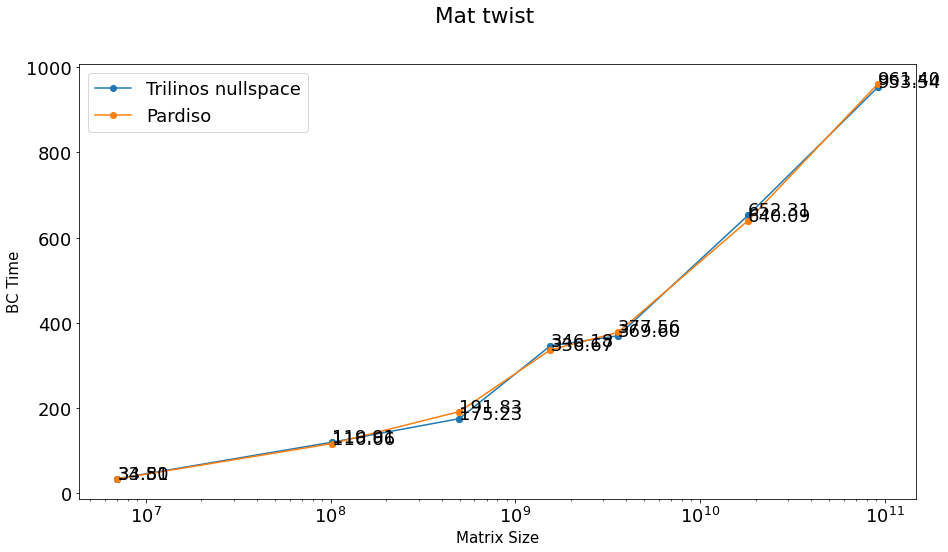

In [10]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["bc_time"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_,marker='o')
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))
num_threads=np.sort(np.int64(twist_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(15,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None
fit("Trilinos","Trilinos nullspace",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),0)
fit("Eigen::PardisoLLT","Pardiso",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),1)
ax.legend()
ax.set_xscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("BC Time",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("Mat twist")

Text(0.5, 0.98, 'Mat twist')

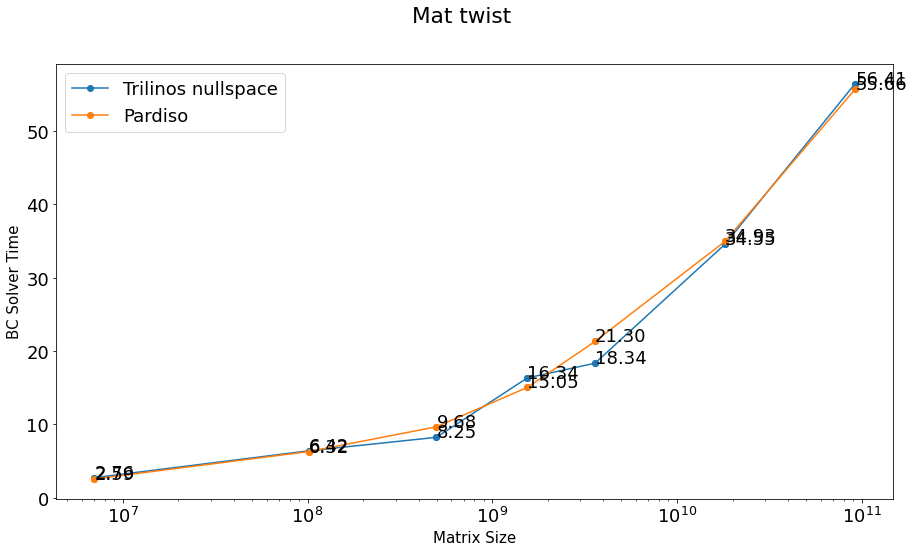

In [11]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["bc_solver_time"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_,marker='o')
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))
num_threads=np.sort(np.int64(twist_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(15,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None
fit("Trilinos","Trilinos nullspace",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),0)
fit("Eigen::PardisoLLT","Pardiso",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),1)
ax.legend()
ax.set_xscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("BC Solver Time",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("Mat twist")

Text(0.5, 0.98, 'Mat twist')

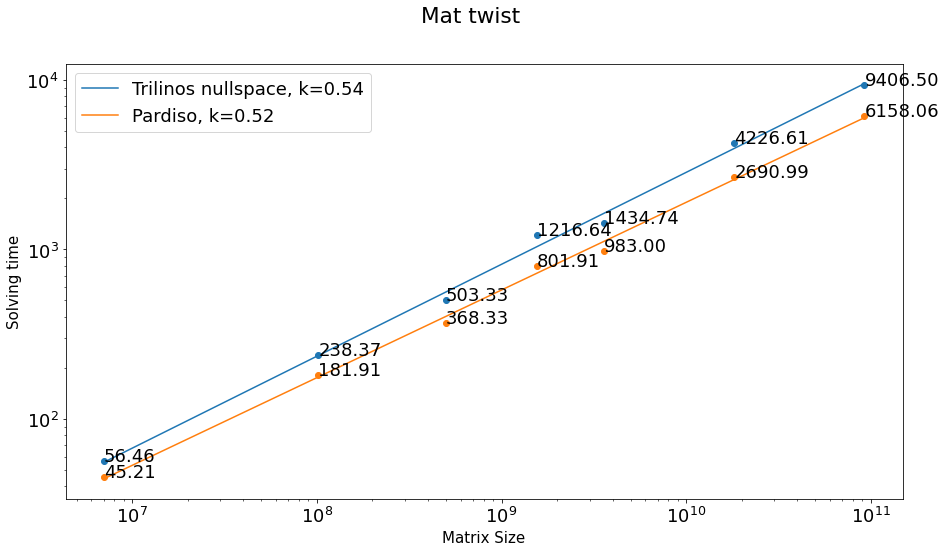

In [12]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.float64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Runtime"])
    logx = np.log(xdata)
    # logx=logx/2
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    # ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_,marker='o')
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos","Eigen::PardisoLLT"]
num_threads=np.sort(np.int64(twist_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(15,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None
fit("Trilinos","Trilinos nullspace",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),0)
fit("Eigen::PardisoLLT","Pardiso",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),1)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Solving time",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("Mat twist")

Text(0.5, 0.98, 'Mat twist')

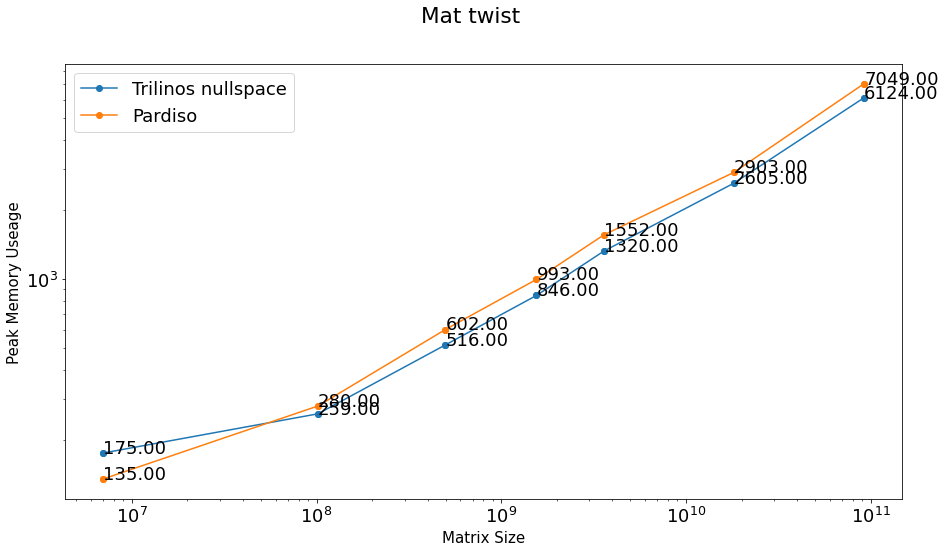

In [ ]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Peak Memory"])
    label_=solverlabel_
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_,marker='o')
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos","Eigen::PardisoLLT"]
num_threads=np.sort(np.int64(twist_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(15,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None
fit("Trilinos","Trilinos nullspace",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),0)
fit("Eigen::PardisoLLT","Pardiso",3,ax,twist_df,list(mcolors.TABLEAU_COLORS),1)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Peak Memory Useage",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("Mat twist")

In [9]:
def output(material,ax,c_index):
    from matplotlib.ticker import MaxNLocator
    # novec_list,_=data_collect([glob.glob("/home/yiwei/result_new_material/novec/"+material+"/**/**/**/**/**/**/**")],6)
    vec_list,_=data_collect([glob.glob("/home/yiwei/result_new_material_newvec/vec/"+material+"/**/**/**/**/**/**/**")],6)
    
    # novec_df=df_create(novec_list)
    vec_df=df_create(vec_list)
    def _fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
        degree=1   
        if mesh_==None:
            tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
        else:
            tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
        tempdf=tempdf.sort_values(by=['num_vertices'])
        xdata=np.int64(tempdf['num_vertices'])
        ydata=np.float64(tempdf["Iterations"])
        ydata_step=np.float64(tempdf["steps"])
        label_=solverlabel_
        # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
        ax_.scatter(xdata,ydata,color=cmap_[cindex_])
        # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
        # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
        ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
        for i in range(len(xdata)):
            ax_.annotate('('+('%d'%ydata[i])+","+('%d'%ydata_step[i])+')', (xdata[i], ydata[i]))

    solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

    num_threads=np.sort(np.int64(vec_df["Num Thread"].unique()))

    plt.rcParams.update({'font.size': 18}) # font size
    label=""
    data_frame=None

    _fit("Trilinos",material+" with nullspace vecotors",3,ax,vec_df,cmap,c_index)
    # _fit("Trilinos",material+" without nullspace vecotors",3,ax,novec_df,cmap,c_index)
    # fit("Trilinos","Trilinos unstructed",2,ax,unstruct_2d_df,cmap,0,"square_beam2d_2.5")
    # fit("Trilinos","Trilinos structed",2,ax,struct_2d_df,cmap,1,"square_beam2d_struct_5")
    # fit("Hypre","Hypre",1,ax,laplace3d_tet,cmap,1)
    # fit("Trilinos","Trilinos",1,ax,laplace3d_tet,cmap,2)
    ax.set_xscale('log')
    ax.legend()
    # fit("Hypre",3,ax,result_df,cmap,3)
    # fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
    # fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
    plt.xticks(fontsize=18, rotation=0)
    plt.yticks(fontsize=18, rotation=0)
    ax.set_ylabel("Iterations",fontsize=15) # y labels
    ax.set_xlabel("Number of vertices",fontsize=15) # x labels

In [10]:
def output_avg_iter(material,ax,c_index):
    from matplotlib.ticker import MaxNLocator
    # novec_list,_=data_collect([glob.glob("/home/yiwei/result_new_material/novec/"+material+"/**/**/**/**/**/**/**")],6)
    vec_list,_=data_collect([glob.glob("/home/yiwei/result_new_material_newvec/vec/"+material+"/**/**/**/**/**/**/**")],6)

    # novec_df=df_create(novec_list)
    vec_df=df_create(vec_list)
    def _fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
        degree=1   
        if mesh_==None:
            tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
        else:
            tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
        tempdf=tempdf.sort_values(by=['num_vertices'])
        xdata=np.int64(tempdf['num_vertices'])
        ydata=np.float64(tempdf["Iterations"])/np.float64(tempdf["steps"])
        ydata_step=np.float64(tempdf["steps"])
        label_=solverlabel_
        # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
        ax_.scatter(xdata,ydata,color=cmap_[cindex_])
        # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
        # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
        ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
        for i in range(len(xdata)):
            ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))

    solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

    num_threads=np.sort(np.int64(vec_df["Num Thread"].unique()))

    plt.rcParams.update({'font.size': 18}) # font size
    label=""
    data_frame=None

    _fit("Trilinos",material+" with nullspace vecotors",3,ax,vec_df,cmap,c_index)
    # _fit("Trilinos",material+" without nullspace vecotors",3,ax,novec_df,cmap,c_index)
    # fit("Trilinos","Trilinos unstructed",2,ax,unstruct_2d_df,cmap,0,"square_beam2d_2.5")
    # fit("Trilinos","Trilinos structed",2,ax,struct_2d_df,cmap,1,"square_beam2d_struct_5")
    # fit("Hypre","Hypre",1,ax,laplace3d_tet,cmap,1)
    # fit("Trilinos","Trilinos",1,ax,laplace3d_tet,cmap,2)
    ax.set_xscale('log')
    ax.legend()
    # fit("Hypre",3,ax,result_df,cmap,3)
    # fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
    # fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
    plt.xticks(fontsize=18, rotation=0)
    plt.yticks(fontsize=18, rotation=0)
    ax.set_ylabel("Iterations",fontsize=15) # y labels
    ax.set_xlabel("Number of vertices",fontsize=15) # x labels

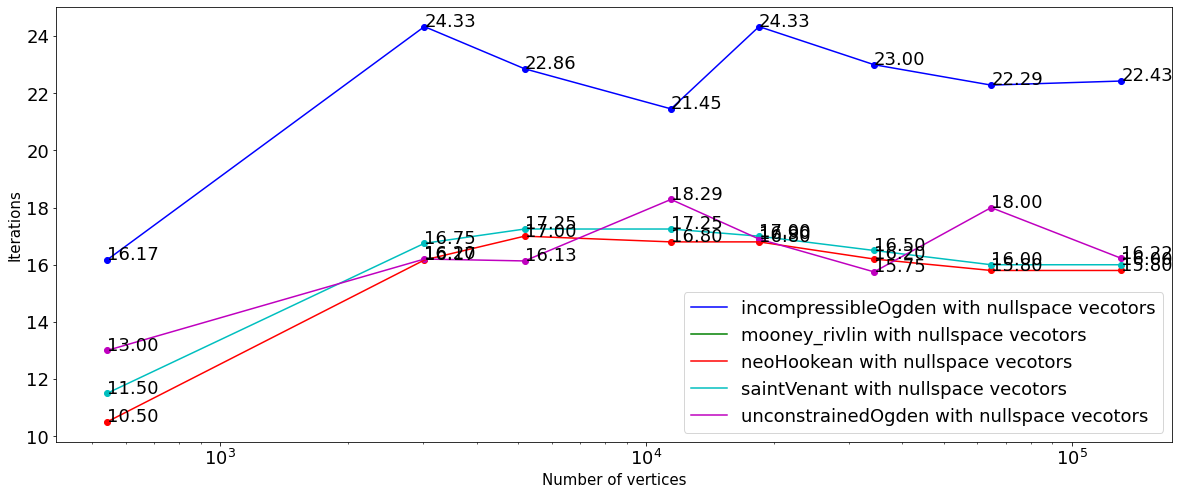

In [11]:
materials=["incompressibleOgden","mooney_rivlin","neoHookean","saintVenant","unconstrainedOgden"]
fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
k=0
for material in materials:
    output_avg_iter(material,ax,k)
    k=k+1

In [13]:
vec_list,_=data_collect([glob.glob("/home/yiwei/result_test/mat-twist/vec/**/**/**/**/**/**/**")],6)
vec_update_list,_=data_collect([glob.glob("/home/yiwei/result_test/mat-twist/vec_updatepos/**/**/**/**/**/**/**")],6)
vec_df=df_create(vec_list)
vec_update_df=df_create(vec_update_list)